Uses Sums-of-Squares Optimization to find a Lyapunov function that proves global stability (except from the set of measure zero representing the upright states) of the fixed points at $\theta^* = 2\pi k$ (with integer $k$) for the damped pendulum.

In [1]:
# Install drake (if necessary) and set up the path.  
try:
  import pydrake
except ImportError:
  !curl -s https://raw.githubusercontent.com/RussTedrake/underactuated/master/scripts/setup/jupyter_setup.py > jupyter_setup.py
  from jupyter_setup import setup_drake
  setup_drake()
# Note: On Google's Colaboratory, this will take a minute, but should only need to reinstall once every 12 hours.
# Colab will ask you to "Reset all runtimes"; say no to save yourself the reinstall.

In [3]:
import numpy as np
from pydrake.all import MathematicalProgram, Solve, Variables
from pydrake.symbolic import Polynomial
from pydrake.examples.pendulum import PendulumParams

prog = MathematicalProgram()

# Declare the "indeterminates", x.  These are the variables which define the polynomials, 
# but are NOT decision variables in the optimization.  We will add constraints below that 
# must hold FOR ALL x.
s = prog.NewIndeterminates(1, 's')[0]
c = prog.NewIndeterminates(1, 'c')[0]
thetadot = prog.NewIndeterminates(1, 'thetadot')[0]
# TODO(russt): bind the sugar methods so I can write x = prog.NewIndeterminates(['s','c','thetadot'])
x = np.array([s, c, thetadot])

# Write out the dynamics in terms of sin(theta), cos(theta), and thetadot
p = PendulumParams()
f = [ c*thetadot, -s*thetadot, (-p.damping()*thetadot - p.mass()*p.gravity()*p.length()*s)/(p.mass()*p.length()*p.length())]

# The fixed-point in this coordinate
x0 = np.array([0,1,0])

# Construct a polynomial V that contains all monomials with s,c,thetadot up to degree 2
deg_V = 2
V = prog.NewFreePolynomial(Variables(x), deg_V).ToExpression()

# Add a constraint to enforce that V is strictly positive away from x0.
# (Note that because our coordinate system is sine and cosine, V is also zero at theta=2pi, etc)
eps = 1e-4
constraint1 = prog.AddSosConstraint(V - eps*(x-x0).dot(x-x0))  # V is strictly positive away from x0

# Construct the polynomial which is the time derivative of V.
Vdot = V.Jacobian(x).dot(f)

# Construct a polynomial L representing the "Lagrange multiplier".
deg_L = 2;
L = prog.NewFreePolynomial(Variables(x), deg_L).ToExpression()

# Add a constraint that Vdot is strictly negative away from x0 (but make an exception for the
# upright fixed point by multipling by s^2)
constraint2 = prog.AddSosConstraint( -Vdot - L*(s**2+c**2-1) - eps*(x-x0).dot(x-x0)*s**2 )

# Add V(0) = 0 constraint
constraint3 = prog.AddLinearConstraint(V.Substitute({s: 0, c: 1, thetadot: 0}) == 0)

# Add V(theta=pi) = mgl, just to set the scale.
constraint4 = prog.AddLinearConstraint(V.Substitute({s: 1, c: 0, thetadot: 0}) == p.mass()*p.gravity()*p.length())

# Call the solver.
result = Solve(prog)
assert(result.is_success())

# Note that I've added mgl to the potential energy (relative to the textbook), so 
# that it would be non-negative... like the Lyapunov function.
print('Mechanical Energy = ')
print(.5*p.mass()*p.length()**2*thetadot**2 + p.mass()*p.gravity()*p.length()*(1-c))

print('V =')
Vsol = Polynomial(result.GetSolution(V));
print(Vsol.RemoveTermsWithSmallCoefficients(1e-6))



Mechanical Energy = 
(4.9050000000000002 * (1 - c(0)) + 0.125 * pow(thetadot(0), 2))
V =
2.3918478312525115*c(0)^2 + 2.5131533745670547*s(0)^2 + 0.030303396539781095*s(0) * thetadot(0) + 0.12827453803995187*thetadot(0)^2 + 2.3918468491343239*1 + -4.7836946237367837*c(0)


<IPython.core.display.Javascript object>


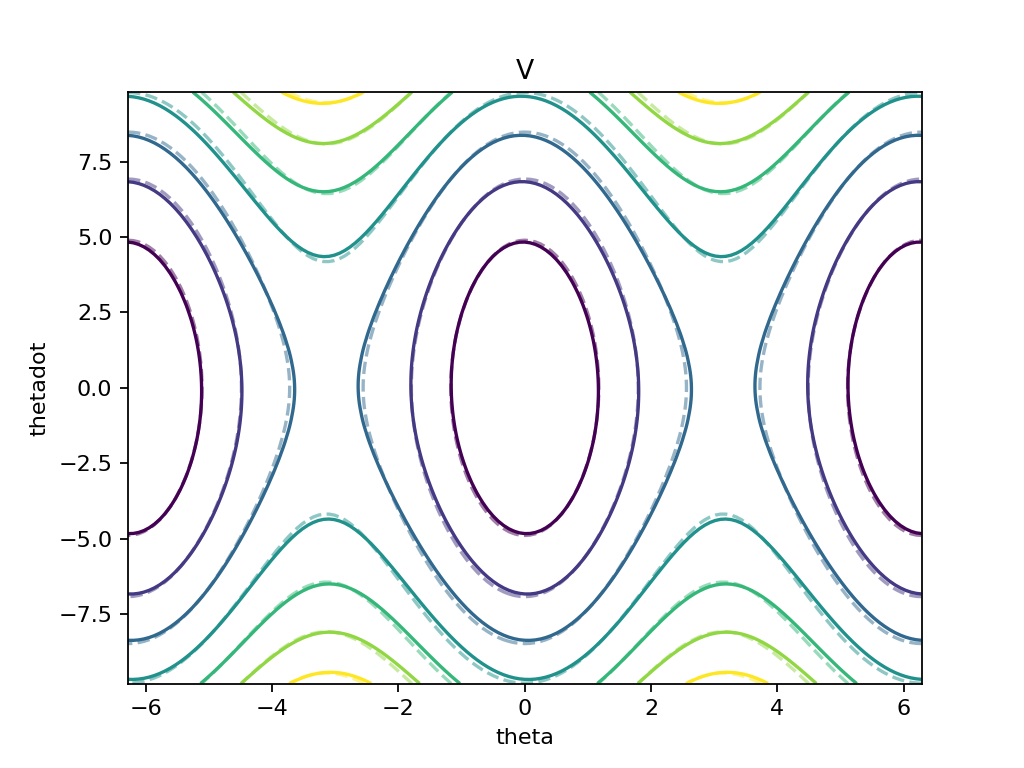

In [9]:
%matplotlib notebook  
import matplotlib.pyplot as plt

# Plot the results: countou
nq = 151
nqd = 151
q = np.linspace(-2*np.pi, 2*np.pi, nq)
qd = np.linspace(-2*p.mass()*p.gravity()*p.length(), 2*p.mass()*p.gravity()*p.length(), nqd)
Q, QD = np.meshgrid(q, qd)
Vplot = Q.copy()
Energy = Q.copy()
env = {s: 0., c: 1., thetadot: 0}
for i in range(nq):
    for j in range(nqd):
        env[s] = np.sin(Q[i, j])
        env[c] = np.cos(Q[i, j])
        env[thetadot] = QD[i, j]
        Vplot[i, j] = Vsol.Evaluate(env)
        Energy[i, j] = .5*p.mass()*p.length()**2*QD[i, j]**2 + p.mass()*p.gravity()*p.length()*(1-np.cos(Q[i, j]))
    
#plt.rc('text', usetex=True)
fig, ax = plt.subplots()
ax.contour(Q, QD, Vplot)
ax.contour(Q, QD, Energy, alpha=0.5, linestyles='dashed')
ax.set_xlabel('theta')
ax.set_ylabel('thetadot')
ax.set_title('V (solid) and Mechanical Energy (dashed)')

plt.show()

In [6]:
# Note: We hard-coded the dynamics above (because we chose to rewrite the coordinate system), 
# but would normally get the equations directly (symbolically) from the plant.  
# I've included a simple example below.

from pydrake.all import Variable
from pydrake.examples.pendulum import PendulumPlant

plant = PendulumPlant().ToSymbolic()
context = plant.CreateDefaultContext()
x = [Variable("q"), Variable("qdot")]
context.SetContinuousState(x)
context.FixInputPort(0, [0])
f = plant.EvalTimeDerivatives(context).get_vector().CopyToVector()

print(f[0])
print(f[1])


qdot
(( - 0.10000000000000001 * qdot - 4.9050000000000002 * sin(q)) / 0.25)
